In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.functions import emission_profile_function
from metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from climate_models.co2_ipcc_climate_model import co2_ipcc_climate_model
from climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model
from scipy.stats import qmc

## Parameters

In [2]:
start_year = 1765
t0 = 2020
time_horizon = 100

sensitivity_rf_co2 = 9.2e-16 # Not used with FaIR
ratio_erf_rf_co2 = 1
efficacy_erf_co2 = 1
unit_value_co2 = 1*10**10

In [3]:
species = "Aviation NOx - CH4 decrease and induced"

In [4]:
if species == "Aviation contrails":
    unit_value = 1*10**10
    variables = {
        "time_horizon": (10, 150),
        "sensitivity_rf": (0.5e-12, 4e-12),
        "ratio_erf_rf": (0.23, 0.87),
        "efficacy_erf": (0.12, 1.0)
    }

elif species == "Aviation NOx - ST O3 increase":
    unit_value = 1*10**10
    variables = {
        "time_horizon": (10, 150),
        "sensitivity_rf": (25.1e-12 * (14/46) / 3, 25.1e-12 * (14/46) * 3),
        "ratio_erf_rf": (1, 1.5),
        "efficacy_erf": (0.8, 1.2)
    }

elif species == "Aviation NOx - CH4 decrease and induced":
    unit_value = 1*10**10
    variables = {
        "time_horizon": (10, 150),
        "sensitivity_rf": (-0.83e-9 * 3, -0.83e-9 / 3),
        "ratio_erf_rf": (1, 1.5),
        "efficacy_erf": (0.8, 1.2)
    }
    
n_samples = 200 
dim = len(variables)

sampler = qmc.LatinHypercube(d=dim)
sample = sampler.random(n=n_samples)

l_bounds = [v[0] for v in variables.values()]
u_bounds = [v[1] for v in variables.values()]
scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

df = pd.DataFrame(scaled_sample, columns=variables.keys())
df["time_horizon"] = df["time_horizon"].round().astype(int)

In [5]:
species_settings_co2 = {"sensitivity_rf": sensitivity_rf_co2, "ratio_erf_rf": ratio_erf_rf_co2, "efficacy_erf": efficacy_erf_co2}

ratr_list = np.zeros(n_samples)

for i in range(0, n_samples):
    
    time_horizon = df["time_horizon"].loc[i]
    sensitivity_rf = float(df["sensitivity_rf"].loc[i])
    ratio_erf_rf = float(df["ratio_erf_rf"].loc[i])
    efficacy_erf = float(df["efficacy_erf"].loc[i])
    
    end_year = t0 + time_horizon
    background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
    model_settings_co2 = {"background_species_quantities": background_species_quantities}
    model_settings = {"background_species_quantities": background_species_quantities}
    
    emission_profile_co2 = emission_profile_function(start_year,t0,time_horizon, 'pulse', unit_value_co2)
    emission_profile = emission_profile_function(start_year,t0,time_horizon, 'pulse', unit_value)
    radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = species_fair_climate_model(start_year, end_year, "Aviation CO2", emission_profile_co2, species_settings_co2, model_settings_co2)
    radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
    agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, efficacy_erf_co2, temperature_co2_unit, time_horizon)
    
    species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
    radiative_forcing, effective_radiative_forcing, temperature = species_fair_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
    radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value
    agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_erf, temperature_unit, time_horizon)
    
    gwp_rf, gwp_erf, egwp_rf, egwp_erf, gtp, igtp, ratr = relative_metrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)
    ratr_list[i] = ratr

In [6]:
df['ratr'] = ratr_list
print(df)

     time_horizon  sensitivity_rf  ratio_erf_rf  efficacy_erf        ratr
0             102   -1.860457e-09      1.215499      0.848147 -241.179195
1              30   -1.068355e-09      1.402565      0.854329 -396.564736
2             121   -3.654785e-10      1.175449      0.943631  -44.499464
3             134   -1.613215e-09      1.368513      0.880912 -196.680686
4              97   -1.590757e-09      1.366707      1.118223 -318.082194
..            ...             ...           ...           ...         ...
195           141   -3.920678e-10      1.074713      1.014444  -41.486543
196           113   -2.405822e-09      1.041544      0.952474 -276.688764
197           108   -1.270695e-09      1.426378      1.088855 -237.175760
198            69   -7.878577e-10      1.430803      1.184259 -228.088109
199            36   -2.257574e-09      1.338788      0.998258 -831.592368

[200 rows x 5 columns]


In [7]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Variables (logarithm)
if species == "Aviation NOx - CH4 decrease and induced":
    X_log = df[["time_horizon", "sensitivity_rf", "ratio_erf_rf", "efficacy_erf"]].copy()
    X_log["sensitivity_rf"] = -X_log["sensitivity_rf"]
    print(X_log)
    X = np.log(X_log)
    y = np.log(-df["ratr"])
    print(X, y)
else:
    X = np.log(df[["time_horizon", "sensitivity_rf", "ratio_erf_rf", "efficacy_erf"]])
    y = np.log(df["ratr"])

# Linear regression (logarithm)
model = LinearRegression()
model.fit(X, y)

coeffs = model.coef_
intercept = model.intercept_
features = X.columns
equation = f"ratr = {intercept:.4f}"
for i in range(len(features)):
    equation += f" + ({coeffs[i]:.4f}) × {features[i]}"
print("Équation de la régression :")
print(equation)

# Assessment
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred)

print(f"\nR² : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")

     time_horizon  sensitivity_rf  ratio_erf_rf  efficacy_erf
0             102    1.860457e-09      1.215499      0.848147
1              30    1.068355e-09      1.402565      0.854329
2             121    3.654785e-10      1.175449      0.943631
3             134    1.613215e-09      1.368513      0.880912
4              97    1.590757e-09      1.366707      1.118223
..            ...             ...           ...           ...
195           141    3.920678e-10      1.074713      1.014444
196           113    2.405822e-09      1.041544      0.952474
197           108    1.270695e-09      1.426378      1.088855
198            69    7.878577e-10      1.430803      1.184259
199            36    2.257574e-09      1.338788      0.998258

[200 rows x 4 columns]
     time_horizon  sensitivity_rf  ratio_erf_rf  efficacy_erf
0        4.624973      -20.102444      0.195155     -0.164701
1        3.401197      -20.657146      0.338303     -0.157439
2        4.795791      -21.729814      0.16165

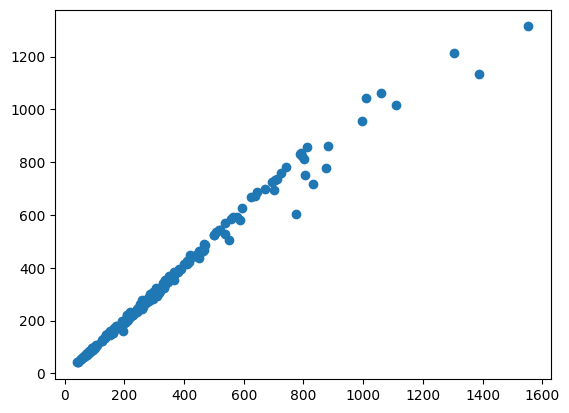

In [8]:
plt.scatter(np.exp(y_pred), np.exp(y))

In [10]:
np.min(((np.exp(y)-np.exp(y_pred))/np.exp(y_pred))*100)


np.float64(-22.010598974398366)

In [ ]:
np.